In [1]:
import networkx as nx
import numpy as np
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
import os
import scipy
from math import sqrt
import numba
from numba import jitclass
from numba import int32, float32, int64, float64
import numpy as np
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib import colors as mcolors
from scipy.interpolate import UnivariateSpline
import string

#from minepy import MINE

In [2]:
from preprocessing_net import get_cyclic_net
from mutual_info import memory_capacity_n
from nrmse_calc import nrmse, nrmse_n

changes


In [3]:
#imports
import entropy_estimators as ee
import scipy.spatial as ss
from scipy.special import digamma,gamma
from math import log,pi
import numpy.random as nr
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
import numpy as np
import random as rand
import scipy

In [4]:
#ESN_class.py imports
import networkx as nx
import numpy as np
import random as rand
import scipy
from preprocessing_net import get_cyclic_net

In [5]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [6]:
@numba.jit(nopython=True)
def colored_noise_euler_integration(res_size,decay,Win,W,x_0, u_0, tau, c, t_stop, dt=0.001):
    np.random.seed(tau)
    mu=np.exp(-dt/tau)
    sigma= sqrt( ((c * tau)/2) * (1-mu**2) )
    
    
    t = np.linspace(0, t_stop, int(t_stop/dt))
    
    x=np.zeros((len(t),res_size))
    x[0,:]=x_0

    u = u_0 * np.ones_like(t)
    
    for i in range(0, len(t) - 1):
        u[i+1] = u[i]* mu + sigma * np.random.normal()
        x[i+1,:] = x[i,:] + dt * dx_act_dt(x[i,:], u[i],res_size,decay,Win,W)
            
    return u,x

In [7]:
#@jitclass(spec,nopython=True)
class ESN(object):
    def __init__(self, filename, in_size, out_size, spectral_radius):
        self.res_size= self.build_adj_weighted_matrix(filename).shape[0]
        self.in_size=in_size
        self.out_size=out_size
        self.spectral_radius= spectral_radius
        self.W0=self.build_adj_weighted_matrix(filename)
        self.W=None
        self.Win=None
        self.Wout=None
        self.X=None
        self.Y=None
        self.x=np.zeros((self.res_size,1))
        self.x0_e=np.random.rand(self.res_size)
        self.x0=np.insert(np.random.rand(self.res_size)*10,0,[1.0,1.0,1.0])
        self.u0=0
        self.decay=np.random.gamma(5.22,0.017,size=self.res_size).reshape((self.res_size,1))
        self.u=None
        self.x_act=None

   
    def build_adj_weighted_matrix(self, filename):
        #NETWORK v2.0
        net=get_cyclic_net(filename)
        for edge in net.edges(data="mode", default=0):
            source,target,mode=edge
            if mode== "+":
                net[source][target]["weight"]= np.random.uniform(0,1)
            elif mode== "-":
                net[source][target]["weight"]= np.random.uniform(-1,0)
            elif mode== 0:
                net[source][target]["weight"]= np.random.uniform(-1,1)
        
        return nx.to_numpy_matrix(net)
    
    def initialize(self,i_scaling,beta_scaling): 
        np.random.seed(tau)
        print("factor i= %.2f"%i_scaling)
        print("factor beta= %.2f"%beta_scaling)
        self.Win=np.random.uniform(size=(self.res_size,1+self.in_size))*i_scaling
        self.Win[:,0]=np.random.uniform(size=(self.res_size,))*beta_scaling
        self.W0 = np.squeeze(np.asarray(self.W0)) 
        radius = np.max(np.abs(np.linalg.eigvals(self.W0)))
        self.W= (self.spectral_radius/radius)*self.W0
        return self.W
    
    def dx_dt(self, uyz_x,t,a,b,c,decay):
        u=uyz_x[0]
        y=uyz_x[1]
        z=uyz_x[2]
        x=uyz_x[3:]
        
        du_dt=-z-y
        dy_dt=u+a*y
        dz_dt=b+z*(u-c)
        dx_dt=self.dx_act_dt(x,u)
        return np.insert(dx_dt,0,[du_dt,dy_dt,dz_dt])
    
    def du_dt_rossler(self,z,y):
        return -z-y
    
    def dy_dt_rossler(self, u, a, y):
        return u+a*y
    
    def dz_dt_rossler(self, b, z, u, c):
        return b+z*(u-c)
    
    def dx_act_dt(self, x,u):
        return dx_act_dt(self.res_size,self.decay,self.Win,self.W, x,u)
    
    def colored_noise_euler_integration(self, x_0, u_0, tau, c, t_stop, dt=0.001):
        return colored_noise_euler_integration(self.res_size,self.decay,self.Win,self.W, x_0, u_0, tau, c, t_stop, dt=0.001)
    
    def rossler_euler_integration(self, x_0, u_0, a, b, c, t_stop, dt=0.001):
        t = np.linspace(0, t_stop, int(t_stop/dt))
    
        x=np.zeros((len(t),self.res_size))
        x[0,:]=x_0

        u = u_0 * np.ones_like(t)
        y = u_0 * np.ones_like(t)
        z = u_0 * np.ones_like(t)
    
        for i in range(0, len(t) - 1):
            u[i+1] = u[i] + dt * self.du_dt_rossler(z[i],y[i])
            y[i+1] = y[i] + dt * self.dy_dt_rossler(u[i],a,y[i])
            z[i+1]= z[i] + dt * self.dz_dt_rossler(b,z[i],u[i],c)
            x[i+1,:] = x[i,:] + dt * self.dx_act_dt(x[i,:], u[i]**2)
            
        return u,x
    
    
    def collect_states(self, data, init_len, train_len, a=0.3):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        for t in range(train_len):
            u = data[t]
            self.x = (1-a)*self.x + a*np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, self.x ) ) 
            if t >= init_len:
                self.X[:,t-init_len]= np.vstack((1,u,self.x))[:,0]
        
        return self.X
    
    def collect_states_derivative_OLD(self, init_len, train_len, test_len, euler, noise,dt=0.001):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        t_stop=train_len+test_len
        
        if not euler:
            print("Collecting states with rossler input using odeint built in...")
            print("Parameters: a= %.2f b= %.2f c= %.2f"%(a,b,c))
            t=np.arange(train_len+test_len)
            uyz_x=scipy.integrate.odeint(self.dx_dt,self.x0,t,args=(a,b,c,self.decay))
            self.u=uyz_x[:,0]
            self.x_act=uyz_x[:,3:]
            
        else:
            
            if noise:
                print("Collecting states with noise input...")
                print("Parameters: tau= %.2f c_n= %.2f"%(tau,c_n))
                u, x_act=self.colored_noise_euler_integration(self.x0_e, self.u0, tau, c_n, t_stop, dt)
                
            else:
                print("Collecting states with rossler input using euler integration...")
                print("Parameters: a= %.2f b= %.2f c= %.2f"%(a,b,c))
                u, x_act=self.rossler_euler_integration(self.x0_e, self.u0, a,b, c, t_stop, dt)

            indexes=[int(t/dt) for t in range(0,t_stop)]
            self.u=u[indexes]
            self.x_act=x_act[indexes]
   
        for t in range(init_len,train_len):
            x_concat=self.x_act[t,:].reshape(self.x_act[t,:].shape[0],1)
            u_concat=self.u[t]
            self.X[:,t-init_len]= np.vstack((1,u_concat,x_concat))[:,0]
               
        return self.X 
    
    def collect_states_in_subsets(self, m, init_len, subset_len, test_len, euler, noise,dt=0.001):
        self.X=np.zeros((self.res_size+self.in_size+1, 1))
        self.u=np.array([])
        self.x_act=np.zeros((1,self.res_size))
        print(self.x_act.shape)
        print(self.X.shape)
        for subset in range(m):
            print("Subset ", str(subset+1))
            X, u, x_act= self.collect_states_derivative(init_len,subset_len,euler,noise,dt)
            print(x_act.shape)
            print(X.shape)
            self.X=np.concatenate((self.X,X),axis=1)
            self.u=np.append(self.u,u)
            self.x_act=np.concatenate((self.x_act,x_act),axis=0)
            
        print("Test subset")
        X, u, x_act= self.collect_states_derivative(init_len,test_len,euler,noise,dt)
        self.u=np.append(self.u,u)
        self.x_act=np.concatenate((self.x_act,x_act),axis=0)
        
        self.X=self.X[:,1:]
        self.x_act=self.x_act[1:,:]
    
    def collect_states_derivative(self, init_len, train_len, euler, noise, dt=0.001):
        X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        t_stop=train_len
            
        if not euler:
            print("Collecting states with rossler input using odeint built in...")
            print("Parameters: a= %.2f b= %.2f c= %.2f"%(a,b,c))
            t=np.arange(train_len+test_len)
            uyz_x=scipy.integrate.odeint(self.dx_dt,self.x0,t,args=(a,b,c,self.decay))
            u=uyz_x[:,0]
            x_act=uyz_x[:,3:]
            
        else:
            
            if noise:
                print("Collecting states with noise input...")
                print("Parameters: tau= %.2f c_n= %.2f"%(tau,c_n))
                u, x_act=self.colored_noise_euler_integration(self.x0_e, self.u0, tau, c_n, t_stop, dt)
                
            else:
                print("Collecting states with rossler input using euler integration...")
                print("Parameters: a= %.2f b= %.2f c= %.2f"%(a,b,c))
                u, x_act=self.rossler_euler_integration(self.x0_e, self.u0, a,b, c, t_stop, dt)

            indexes=[int(t/dt) for t in range(0,t_stop)]
            u=u[indexes]
            x_act=x_act[indexes,:]
   
        for t in range(init_len,train_len):
            x_concat=x_act[t,:].reshape(x_act[t,:].shape[0],1)
            u_concat=u[t]
            X[:,t-init_len]= np.vstack((1,u_concat,x_concat))[:,0]
               
        return X, u[init_len:], x_act[init_len:,:]
     
        
    def calculate_weights(self, data, init_len, train_len,beta=1e-6 ):
        Y=data[None,init_len:train_len]
        X_T=self.X.T
        self.Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(self.X,X_T) + beta * np.eye(self.res_size+self.in_size+1)))
        return self.Wout
    
    def calculate_weights_derivative(self,init_len, subset_len, m, n, beta=1e-8 ):
        start_len= (subset_len-init_len) * m
        Y=np.array([self.u[init_len-n:start_len-n]])
        X=self.X[:,init_len:]
        X_T=X.T
        self.Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(X,X_T) + beta * np.eye(self.res_size+self.in_size+1))) #w= y*x_t*(x*x_t + beta*I)^-1
        return self.Wout
    
    def run_predictive_derivative(self, test_len, subset_len,init_len,m):
        self.Y = np.zeros((self.out_size,test_len))
        start_len= (subset_len-init_len) * m
        for t in range(start_len,start_len+(test_len-init_len)):
            x_concat=self.x_act[t,:].reshape(self.x_act[t,:].shape[0],1)
            u_concat=self.u[t]
            y = np.dot( self.Wout, np.vstack((1,u_concat,x_concat)) )
            self.Y[:,t-start_len] = y
            
    def calculate_weights_derivative_OLD(self,init_len, train_len, n, beta=1e-8 ):
        Y=np.array([self.u[init_len-n:train_len-n]])
        X_T=self.X.T
        self.Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(self.X,X_T) + beta * np.eye(self.res_size+self.in_size+1))) #w= y*x_t*(x*x_t + beta*I)^-1
        return self.Wout
    
    def run_predictive_derivative_OLD(self, test_len, train_len):
        self.Y = np.zeros((self.out_size,test_len))
        for t in range(train_len,train_len+test_len):
            x_concat=self.x_act[t,:].reshape(self.x_act[t,:].shape[0],1)
            u_concat=self.u[t]
            y = np.dot( self.Wout, np.vstack((1,u_concat,x_concat)) )
            self.Y[:,t-train_len] = y
           
        return self.Y


In [8]:
##################################################################################

In [9]:
@numba.jit(nopython=True)
def dx_act_dt(x,u,res_size,decay,Win,W):
        x=x.reshape(res_size,1)
        x_act=decay*0.5*(np.tanh( np.dot( Win, np.vstack((np.array(1),np.array(u)) )) + np.dot( W, x ) )+1) - (decay * x)
        return x_act.reshape(res_size)

In [10]:
#                                   FUNCTIONS                                    #

In [11]:
def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    result=result[int(result.size/2):]
    return result/result[0]

In [12]:
def testing_gene_net(directory,input_data,data):
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]
    print(csv_files)
    MI_by_file={}
    for file in csv_files:
        filename=file[file.index("list")+5:file.index(".csv")]
        net=ESN(os.path.join(directory, file),1,1,0.95)
        net.initialize()
        net.collect_states(input_data,initLen,trainLen)
        net.calculate_weights(input_data,initLen,trainLen)
        net.run_generative(input_data,testLen,trainLen)
      
        MI_by_file[filename]=memory_capacity_n(net.Y, data,100)
        nrmse= sqrt(mean_squared_error(data[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
        print(net.res_size, 'NRMSE = ' + str( nrmse ))
        print(memory_capacity_n(net.Y, data,20))
        
    return MI_by_file

In [13]:
def testing_gene_net_file(directory,file):
    print(file)
    filename=file[file.index("list")+5:file.index(".csv")]
    net=ESN(os.path.join(directory, file),1,1,0.95)
    net.initialize()
    net.collect_states(data,initLen,trainLen)
    net.calculate_weights(data,initLen,trainLen)
    net.run_generative(data,testLen,trainLen)
    nrmse= sqrt(mean_squared_error(data[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
    print(net.res_size, 'NRMSE = ' + str( nrmse ))
    return memory_capacity_n(net.Y, data,100)

In [14]:
def test_all(directory,folder,spectral_radius, n_range, nrmse, noise, euler=True, save=False):
    #init
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]
    Y_by_file={}
    X_by_file={}
    MI_by_file={}
    NRMSE_by_file={}
    
    for file in csv_files:
        net,X,Y,nrmse_by_n,mi_by_n,filename= test(directory,file,folder,spectral_radius, n_range, nrmse, noise, euler, save, single=False)
        X_by_file[filename]=X
        Y_by_file[filename]=Y
        MI_by_file[filename]=mi_by_n
        NRMSE_by_file[filename]=nrmse_by_n
        
        #plots
    for n in n_range:    
        figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
        title("n="+str(n))
        if nrmse:
            plot_dict_by_file(NRMSE_by_file,n,tau,folder, nrmse, save)
        else:
            plot_dict_by_file(MI_by_file,n,tau,folder, nrmse, save)
        
    return X_by_file, Y_by_file, NRMSE_by_file, MI_by_file
  


In [15]:
def gride_function(to_optimize, *params):
    i_scaling, beta_scaling =to_optimize
    directory,file,folder,spectral_radius,n_range, nrmse, noise=params
    net,nrmse_by_n,mi_by_n,MImax_n,FWHM= test(directory,file,folder,spectral_radius, i_scaling,beta_scaling,n_range, nrmse, noise)
    return min(nrmse_by_n[0].values())

In [16]:
def test(directory,file_path, folder, spectral_radius, i_scaling,beta_scaling,n_range, nrmse, noise, euler=True, save=False, single=True, gaussian=False, notebook=True):
    #init
    print(file_path)
    filename=file_path[file_path.index("list")+5:file_path.index(".csv")]

    #Run network
    print("Running network...")
    net=ESN(os.path.join(directory, file_path),1,1,spectral_radius)
    np.random.seed(42)
    net.initialize(i_scaling,beta_scaling)
    print("SR", net.spectral_radius)
    
    #Choose input and collect states
    net.collect_states_derivative_OLD(initLen, trainLen, testLen, euler, noise,dt=0.001)
    #X=net.u
    print(net.u.shape)
    

    
    if notebook=="ahora no":
        #plot reservoir units activations
        figure(num=None, figsize=(20, 4), dpi=80, facecolor='w', edgecolor='k')
        title("Reservoir activations")
        plot(net.X[2:20,500:1000].T)
        
        if noise:
            print("Autocorrelation of generated noise")
            autocorr=autocorrelation(net.u)
            exponential_fitting(autocorr,exp_func)
    
    #train for n steps delay
    print("Training network...")
    Y_n={}
    mi_by_n={}
    nrmse_by_n={}
    MImax_n={}
    figure(figsize=(30, 5),dpi=80, facecolor='w', edgecolor='k')
    
    
    for index,n in enumerate(n_range):
        print("n=",n)
        
    
        

        net.calculate_weights_derivative_OLD(initLen,trainLen,n)
        net.run_predictive_derivative_OLD(testLen,trainLen)
    
        #if noise and n==0 and notebook:
        if notebook=="ahora no":
            figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
            legend(["Noise signal",'Target signal with delay n= {}'.format(n)],fontsize=12)
            plot( net.u[trainLen:trainLen+500], color=colors['navy'] )
            plot( net.u[trainLen-n:trainLen+500-n], color=colors['lightblue'] )
            tick_params(axis='both', labelsize=12)
            xlabel("time",fontsize=16,labelpad=0.6)
            ylabel("signal",fontsize=16)
            print("Autocorrelation of predicted noise")
            autocorr=autocorrelation(net.Y.reshape(net.Y.shape[1]))
            exponential_fitting(autocorr,exp_func)
            
        #mi_by_n[n]=memory_capacity_n(net.Y, net.u,(subsetLen-initLen)*m,500,i_max)
        mi_by_n[n]=memory_capacity_n(net.Y, net.u,trainLen,miLen,i_max,n_max)
        #nrmse_by_n[n]=nrmse_n(net.Y,net.u,i_max,errorLen,(subsetLen-initLen)*m)
        nrmse_by_n[n]=nrmse_n(net.Y,net.u,i_max,errorLen,trainLen,n_max)
        
        #Plots
        print("%d trained to n =%d delay FINISHED" %(net.res_size,n))
        
        if nrmse:
            plot_dict_i(filename, nrmse_by_n[n],MImax_n,n,index,nrmse,single,notebook)
            
        else:
            plot_dict_i(filename, mi_by_n[n],MImax_n,n,index,nrmse,single,notebook)
        
        if notebook=="ahora no":
            figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
            plot_temporal_lines(net.u,net.Y, n,500,filename, tau, folder, save)
            
            figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
            plot_temporal_lines(net.u,net.Y, n, 50,filename, tau, folder ,save)
        
        Y=net.Y
        Y_n[n]=Y
    

    show()
    
    

       
    return net,Y_n,nrmse_by_n,mi_by_n,MImax_n

In [17]:
scipy.stats.distributions.lognorm(0.01,0.1,0.02)

In [53]:
def plot_dict_i(key,dict_i,MImax_n,n,index,ax,max_value,nrmse=True, single=True, notebook=False):
    x=[]
    y=[]
    
    if nrmse:
        name='dodgerblue'
        print("Plot nrmse")
        point=min(dict_i, key=dict_i.get)
        print(key,"=> min=",point, "value", dict_i[point])
    else:
        name="teal"
        print("Plot mi")
        point=max(dict_i, key=dict_i.get)
        print(key,"=> max=",point, "value", dict_i[point])
        MImax_n[n]=dict_i[point]
        
    for i,value in dict_i.items():
        x.append(i)
        y.append(value)
    
    if notebook:


        ax.plot(y,"-o",color=colors[name])
        #h=ax.plot(y,"-o")
        ax.tick_params(axis='both', labelsize=22)
        ax.set_title("n="+str(n),fontsize=30)
        ax.text(-0.19, 1.1, string.ascii_lowercase[index]+")", transform=ax.transAxes, 
            size=30)
        
        
        
        #plot(point,dict_i[point],marker='o')
        #annotate("{:.2}".format(dict_i[point]),xy=(point,dict_i[point]),xytext=(point+0.01,dict_i[point]+0.01),fontsize=14)
        
    
    
        if single and index==50:
            ax1.set_xlabel("i",fontsize=30)
        #return h
        
           

In [49]:
nrmse_by_n

{0: array([[ 0.19209573,  0.11251769,  0.09152935,  0.11319756,  0.10051031,
         -0.01075621,  0.04005341, -0.01986309, -0.03585694,  0.09045983,
         -0.03152423, -0.13524004,  0.01137493, -0.05737546,  0.00305655,
         -0.04469444, -0.03128876, -0.0082929 ,  0.00494711,  0.06516487,
          0.03995757, -0.01875971, -0.06668549, -0.06646686, -0.05005384,
         -0.06605525, -0.07644175, -0.14107014, -0.31313152, -0.33280575,
         -0.25747394, -0.36376656, -0.24625361, -0.3228979 , -0.39259215,
         -0.31818847, -0.36781817, -0.22019103, -0.15135932, -0.00488957,
         -0.13379505, -0.04725502, -0.0883918 ,  0.02306253, -0.08382279,
          0.02725399,  0.1255192 ,  0.02369445,  0.09190104,  0.27971566,
          0.27075422,  0.23635892,  0.09606143,  0.28486502,  0.32454224,
          0.41701322,  0.3575899 ,  0.30806608,  0.30081839,  0.33167417,
          0.34865559,  0.23793518,  0.25614106,  0.2882853 ,  0.24832761,
          0.3116054 ,  0.21163925, 

Plot nrmse
key => min= 0 value 1.14574103392e-05
Plot mi
key => max= 0 value 0.299679993678
Plot nrmse
key => min= 1 value 0.248641639125
Plot mi
key => max= 1 value 0.163080927814
Plot nrmse
key => min= 5 value 0.365934066991
Plot mi
key => max= 5 value 0.132589359124
Plot nrmse
key => min= 9 value 0.469805096325
Plot mi
key => max= 9 value 0.115386541895


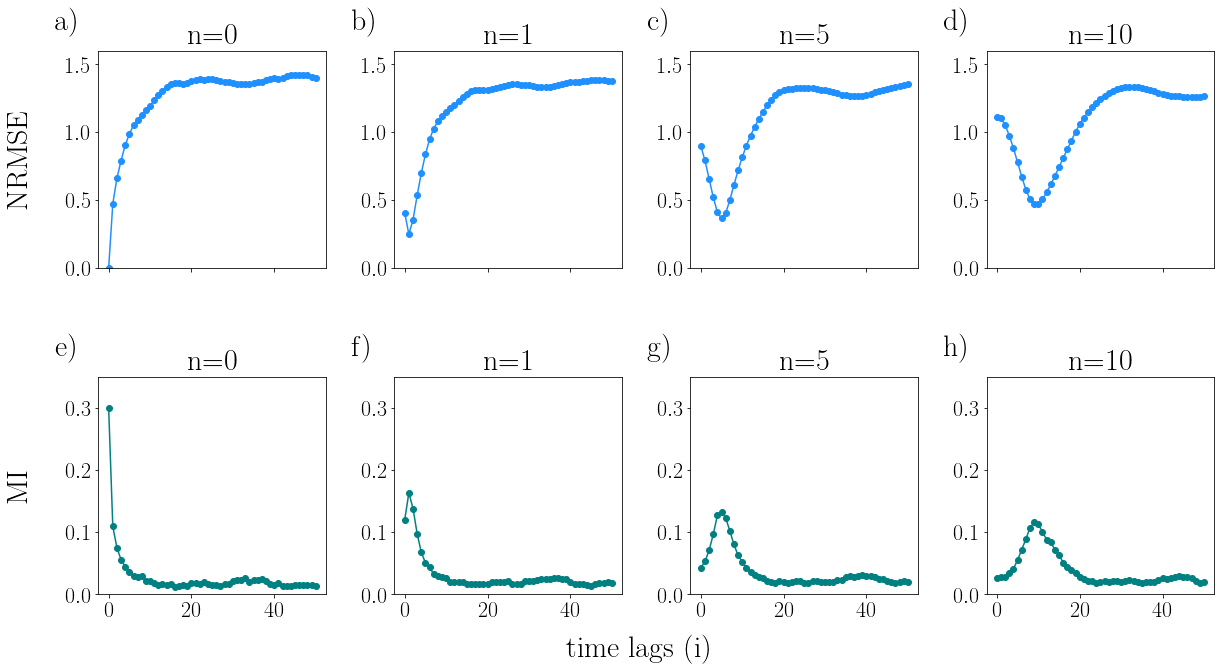

In [54]:
fig, axes = subplots(nrows=2, ncols=4, sharex=True, sharey=False, figsize=(20, 10))
subplots_adjust(wspace=0.3,hspace=0.5)
fig.text(0.5, 0.04, 'time lags (i)', ha='center',fontsize=30)
for i,n in enumerate([0,1,5,10]):
    if i==0:
        axes[0,i].text(-0.4, 0.5, 'NRMSE', va='center',rotation="vertical",fontsize=30,transform=axes[0,i].transAxes)
        axes[1,i].text(-0.4, 0.5, 'MI', va='center',rotation="vertical",fontsize=30,transform=axes[1,i].transAxes)
        #axes[0,i].text(-0.5, 1.2, '1.', va='center',fontsize=30,fontweight="heavy",transform=axes[0,i].transAxes)
        #axes[1,i].text(-0.5, 1.2, '2.', va='center',fontsize=30,fontweight="heavy",transform=axes[1,i].transAxes)
    axes[0,i].set_ylim(bottom=0,top=1.6)
    plot_dict_i("key",nrmse_by_n[n],MImax_n,n,i,axes[0,i],1.6,nrmse=True, single=True, notebook=True)
    axes[1,i].set_ylim(bottom=0,top=0.35)
    plot_dict_i("key",mi_by_n[n],MImax_n,n,i+4,axes[1,i],0.2,nrmse=False, single=True, notebook=True)
show()

In [ ]:
for i,n in enumerate([0,1,5,10]):      
    for file_name, (mi_by_n,nrmse_by_n) in files_dict.items():
        print(file_name)
        print(min(mi_by_n[n].values()))

Plot nrmse
ENCODE => min= 0 value 4.61770492196e-05
Plot mi
ENCODE => max= 0 value 0.299679993678
Plot nrmse
modENCODE => min= 0 value 2.85928518851e-05
Plot mi
modENCODE => max= 0 value 0.299679993678
Plot nrmse
YEASTRACT => min= 0 value 4.8400923135e-05
Plot mi
YEASTRACT => max= 0 value 0.299679993678
Plot nrmse
EcoCyc => min= 0 value 6.06209610641e-06
Plot mi
EcoCyc => max= 0 value 0.299679993678
Plot nrmse
DBTBS => min= 0 value 3.16138280674e-06
Plot mi
DBTBS => max= 0 value 0.299679993678
Plot nrmse
ENCODE => min= 1 value 0.253688152895
Plot mi
ENCODE => max= 1 value 0.166175488546
Plot nrmse
modENCODE => min= 1 value 0.21377828264
Plot mi
modENCODE => max= 1 value 0.179517044969
Plot nrmse
YEASTRACT => min= 1 value 0.239801070592
Plot mi
YEASTRACT => max= 1 value 0.169842262455
Plot nrmse
EcoCyc => min= 1 value 0.260443090111
Plot mi
EcoCyc => max= 1 value 0.161976814427
Plot nrmse
DBTBS => min= 1 value 0.278665656503
Plot mi
DBTBS => max= 1 value 0.155546126797
Plot nrmse
ENCODE

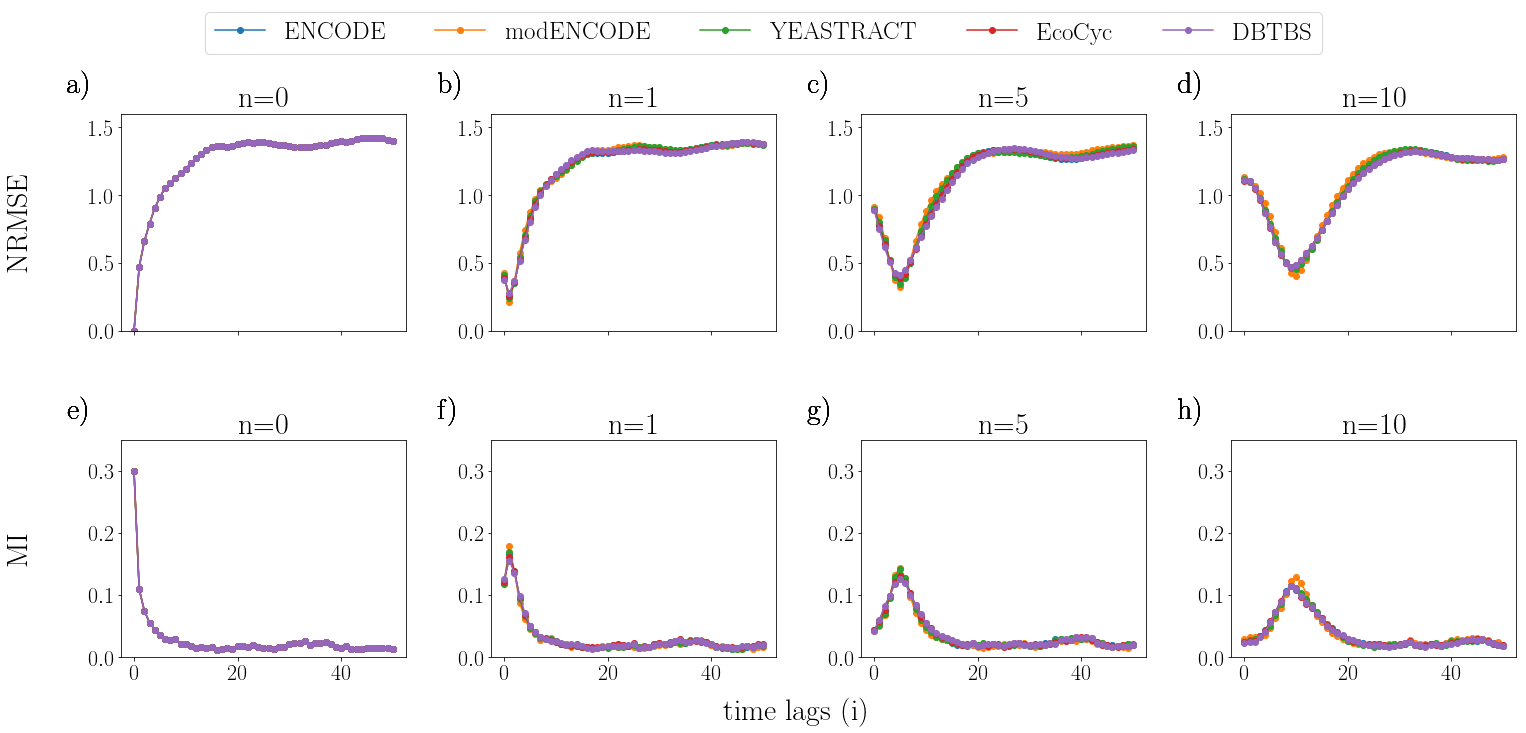

In [44]:

fig, axes = subplots(nrows=2, ncols=4, sharex=True, sharey=False, figsize=(25, 10))
subplots_adjust(wspace=0.3,hspace=0.50)
fig.text(0.5, 0.04, 'time lags (i)', ha='center',fontsize=30)
fig.text(0.5, 1, "empty", ha='center',fontsize=30,color="white")
h={}
for i,n in enumerate([0,1,5,10]):
    if i==0:
        axes[0,i].text(-0.4, 0.5, 'NRMSE', va='center',rotation="vertical",fontsize=30,transform=axes[0,i].transAxes)
        axes[1,i].text(-0.4, 0.5, 'MI', va='center',rotation="vertical",fontsize=30,transform=axes[1,i].transAxes)
        
    for file_name, (mi_by_n,nrmse_by_n) in files_dict.items():
        axes[0,i].set_ylim(bottom=0,top=1.6)
        h[file_name]=plot_dict_i(file_name,nrmse_by_n[n],MImax_n,n,i,axes[0,i],1.6,nrmse=True, single=True, notebook=True)
        axes[1,i].set_ylim(bottom=0,top=0.35)
        h_2=plot_dict_i(file_name,mi_by_n[n],MImax_n,n,i+4,axes[1,i],0.2,nrmse=False, single=True, notebook=True)


axes_h=[]
axes_txt=[]
for file_name in h:
    axes_h.append(h[file_name][0])
    axes_txt.append(r'{}'.format(file_name))

figlegend(axes_h,axes_txt,fontsize=25,ncol=5,loc='upper center')
show()

In [21]:
def plot_dict_by_file(dict_by_file,n,tau,folder,nrmse=True,save=True):
    for file in dict_by_file.keys():
        plot_dict_i(file, dict_by_file[file][n],nrmse=nrmse,single=False)
    legend(loc='upper left')
    xlabel("i=[0,%d]"%(len(dict_by_file[file][n].keys())-1))
    
    if nrmse:
        ylabel("NRMSE(X(t-i), Y(t))",fontsize=20)
    else:
        ylabel("MI(X(t-i), Y(t))",fontsize=20)
        
    if save:
        savefig("plots/nrmse_i_all_files/%s/nrmse_all_n%d_tau_%s" %(folder,n,str(tau)))
    show()

In [22]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


In [23]:
def plot_temporal_lines(u,Y,n,length,filename, tau,folder,save=True):
    #plot( u[startLen-n:startLen+length-n], 'g' )
    #name=["crimson","royalblue","seagreen"]
    #rc('text', usetex=True)
    #rc('font', family='serif')
    ax2.plot( u[trainLen-n:trainLen+length-n], color=colors['dodgerblue'],linewidth=5 )
    ax2.plot( Y.T[0:length],"--", color=colors['crimson'],linewidth=3 )
    ax2.tick_params(axis='both', labelsize=20)
    ax2.text(-0.1, 1.1, "b)", transform=ax2.transAxes, size=20)
    #xlabel("time",fontsize=40
    #ylabel("signal",fontsize=40)
    #title('Target and generated signals $y(t)$ starting at $t=0$ until $t=%s$ with a delay of n=%d ' %(length,n),fontsize=16)
    ax2.legend(['Noise signal with delay n= {}'.format(n), "Predicted signal"],fontsize=18)
    if save:
        savefig("plots/input-vs-output/%s/%s_len%d_n%d_tau%s" %(folder,filename,length,n,str(tau)))
    show()

In [24]:
def func_sum_exp(x, a, b, c,d,e):
    return a * np.exp(-1/b * x)+ c * np.exp(-1/d * x) + e

In [25]:
def exp_func(x, a, b,c):
    return a * np.exp(-1/b * x)+c

In [26]:
def power_law_func(x, e,f,d):
    return x**e * f+d

In [27]:
def func_sum_exp_power_law(x,a,b,e,f,d):
    return a * np.exp(-1/b * x) + x**e * f+d

In [28]:
def func_power_law(x,e,f,d):
    return x**e * f+d

In [29]:
def exponential_fitting(x, func,p0=None,start_point=0,MI=False):
    if MI: #x is MI
        xdata=np.array(list(x.keys())[start_point:])
        ydata=np.array(list(x.values())[start_point:])
    else: #x is autocorr
        a=x[:np.argmax(x<0)]
        ydata=a
        xdata=np.arange(a.shape[0])
    popt, pcov = curve_fit(func, xdata, ydata,p0)
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plot(xdata, ydata, '-o', label='data')
    plot(xdata, func(xdata, *popt), 'r-', label="fit")
    #plot(xdata, exp_func(xdata, popt[0],tau,popt[2]), 'b-', label="expected fit")
    xlabel('n',fontsize=20)
    ylabel('MImax',fontsize=20)
    legend(loc=1, prop={'size': 20})
    return popt,xdata,ydata

In [30]:
def spline_plotting(x,y,nrmse):
    if not nrmse:
        spline = UnivariateSpline(x, y-np.max(y)/2, s=0)
        r1, r2 = spline.roots() # find the roots
    else:
        spline = UnivariateSpline(x, y-np.max(abs(y))/2, s=0)
        r1, r2 = spline.roots() # find the roots
    FWHM=abs(r1-r2)
    print("r1=%f and r2=%f"%(r1,r2))
    print("FWHM",FWHM)
    plot(x, y)
    plot(r1,0,marker='o')
    plot(r2,0,marker='o')
    axvspan(r1, r2, facecolor='g', alpha=0.5)
    show()
    return FWHM

In [31]:
def plot_dict_i_FWHM(key,dict_i,MImax_n,n,nrmse=True, single=True, gaussian=False):
    x=[]
    y=[]
    FWHM=0
    
    if nrmse:
        point=min(dict_i, key=dict_i.get)
        print(key,"=> min=",point, "value", dict_i[point])
    else:
        point=max(dict_i, key=lambda y: abs(dict_i[y]))
        print(key,"=> max=",point)
        MImax_n[n]=abs(dict_i[point])
        
    for i,value in dict_i.items():
        x.append(i)
        y.append(value)
    
  
    plot(y,"-o",color=colors["teal"])
    tick_params(axis='both', labelsize=20)
    title("n="+str(n),fontsize=26)
    
    
    if single:
        xlabel("time lags (i)",fontsize=26)
        
        if nrmse:
            ylabel("NRMSE(X(t-i), Y(t))")
        else:
            ylabel("Mutual Information",fontsize=26)
    if gaussian:
        FWHM = spline_plotting(x,y,nrmse)
    
    return FWHM

In [32]:
##################################################################################

In [33]:
def test_FWHM(directory,file,folder,spectral_radius, n_range, nrmse, noise, euler=True, save=False, single=True, gaussian=False):
    #init
    print(file)
    filename=file[file.index("list")+5:file.index(".csv")]
    
    #Run network
    print("Running network...")
    net=ESN(os.path.join(directory, file),1,1,spectral_radius)
    np.random.seed(42)
    net.initialize(i_scaling,beta_scaling)
    print("SR", net.spectral_radius)
    
    #Choose input and collect states
    net.collect_states_derivative_OLD(initLen, trainLen, testLen, euler, noise,dt=0.001)
    X=net.u
    print(X.shape)
    
    if noise=="ahora no":
        print("Autocorrelation of generated noise")
        autocorr=autocorrelation(X)
        exponential_fitting(autocorr,exp_func)
    
    #plot reservoir units activations
    figure(num=None, figsize=(9, 7), dpi=80, facecolor='w', edgecolor='k')
    title("Reservoir activations")
    plot(net.X[2:20,100:200].T)
    show()
    
    #train for n steps delay
    print("Training network...")
    Y_n={}
    mi_by_n={}
    nrmse_by_n={}
    MImax_n={}
    for n in n_range:
        print("n=",n)
        net.calculate_weights_derivative_OLD(initLen,trainLen,n)
        net.run_predictive_derivative_OLD(testLen,trainLen)
    
        #Calculate output
        Y=net.Y
        Y_n[n]=Y
        
        if noise:
            print("Autocorrelation of predicted noise")
            autocorr=autocorrelation(Y.reshape(Y.shape[1]))
            exponential_fitting(autocorr,exp_func)
            
        mi_by_n[n]=memory_capacity_n(net.Y, net.u,trainLen,miLen,i_max,n_max)
        #nrmse_by_n[n]=nrmse_n(net.Y,net.u,i_max,errorLen,(subsetLen-initLen)*m)
        nrmse_by_n[n]=nrmse_n(net.Y,net.u,i_max,errorLen,trainLen,n_max)
        
        #Plots
        print("%d trained to n =%d delay FINISHED" %(net.res_size,n))
        
        if single:
            figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
            title("n="+str(n))

            if nrmse:
                print("Plot nrmse")
                FWHM=plot_dict_i_FWHM(filename, nrmse_by_n[n],MImax_n,n,nrmse=True,gaussian=True)
                if save:
                    savefig("plots/folder/%s/%s_n%d_tau_%d" %(folder,filename,n,tau))
            else:
                print("Plot mi")
                FWHM=plot_dict_i_FWHM(filename, mi_by_n[n],MImax_n,n,nrmse=False,gaussian=gaussian)
                
            show()
    
    return net,X,Y_n,nrmse_by_n,mi_by_n,filename,MImax_n,FWHM

In [34]:
#                                  PARAMETERS                                    #

In [35]:
# TRAINING AND TEST LENGHT
errorLen = 500
trainLen=2000
testLen=1000
miLen=500
initLen=200
subsetLen=5200
m=10
startLen=(subsetLen-initLen)*m
i_max=50

#Files
csv_files=['network_edge_list_ENCODE.csv', 'network_edge_list_modENCODE.csv', 'network_edge_list_YEASTRACT.csv', 'network_edge_list_EcoCyc.csv', 'network_edge_list_DBTBS.csv']


In [38]:
##################################################################################

In [39]:
#                                   TESTEOS                                      #

In [38]:
# TESTEO get_cyclic_net
G=get_cyclic_net(os.path.join("Dataset1/", "network_edge_list_modENCODE.csv"))
len(G.nodes())

486

In [39]:
#TESTEO adjacency matrix
net=ESN(os.path.join("Dataset1/", "network_edge_list_DBTBS.csv"),1,1,0)
net.W0

matrix([[ 0.        , -0.35846294,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [-0.15487511,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [-0.0965533 , -0.29175356,  0.        , -0.84202428,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.33312288,  0.        ,  0.        ],
        [ 0.        ,  0.71305931,  0.71914205,  0.22474781,  0.        ,
          0.52230713,  0.21296906,  0.5392826 ,  0.07694852,  0.0135386 ,
          0.02671854,  0.        ,  0.        ],
        [ 0.   

In [39]:
#TESTEO initialize
net.initialize()
print(net.W.shape)
print(max(abs(scipy.linalg.eig(net.W)[0])))

TypeError: initialize() missing 2 required positional arguments: 'i_scaling' and 'beta_scaling'

In [ ]:
##################################################################################

In [40]:
#                             RESULTS  NOISE                                         #

In [50]:
# SINGLE FILE:
file=csv_files[0]

## N range
i_max=50
n_max=500
#n_range=list(range(n_max))
n_range=[0,1,5,10]

#parameters
i_scaling=0.05
beta_scaling=0.05
file

'network_edge_list_ENCODE.csv'

In [42]:
# COLORED NOISE

In [ ]:
plot_dict_i(filename, nrmse_by_n[n],MImax_n,n,index,nrmse,single,notebook)

In [37]:
## Parameters
tau=10
c_n=(1/tau)**2
c_n

0.010000000000000002

network_edge_list_ENCODE.csv
Running network...
factor i= 0.05
factor beta= 0.05
SR 0.95
Parameters: tau= 10.00 c_n= 0.01
(3000,)
Training network...
n= 0
207 trained to n =0 delay FINISHED
Plot nrmse
ENCODE => min= 16 value 0.0123163752495
n= 1
207 trained to n =1 delay FINISHED
Plot nrmse
ENCODE => min= 44 value 0.013112724749
n= 5
207 trained to n =5 delay FINISHED
Plot nrmse
ENCODE => min= 47 value 0.0175636285307
n= 10
207 trained to n =10 delay FINISHED
Plot nrmse
ENCODE => min= 50 value 0.0178116743368


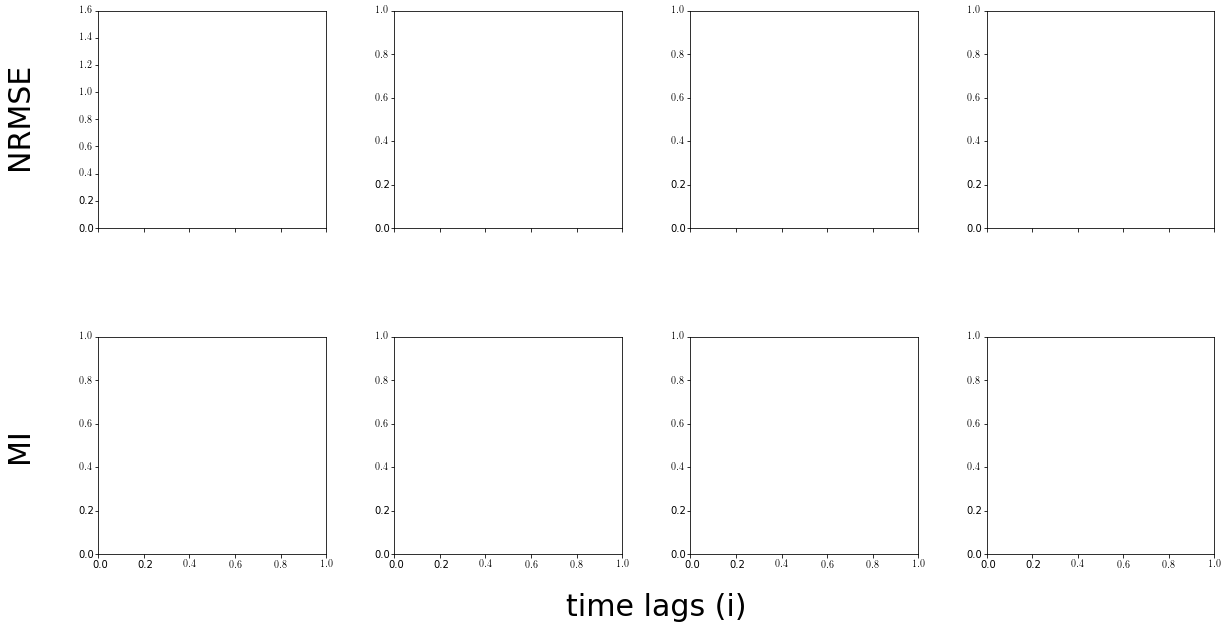

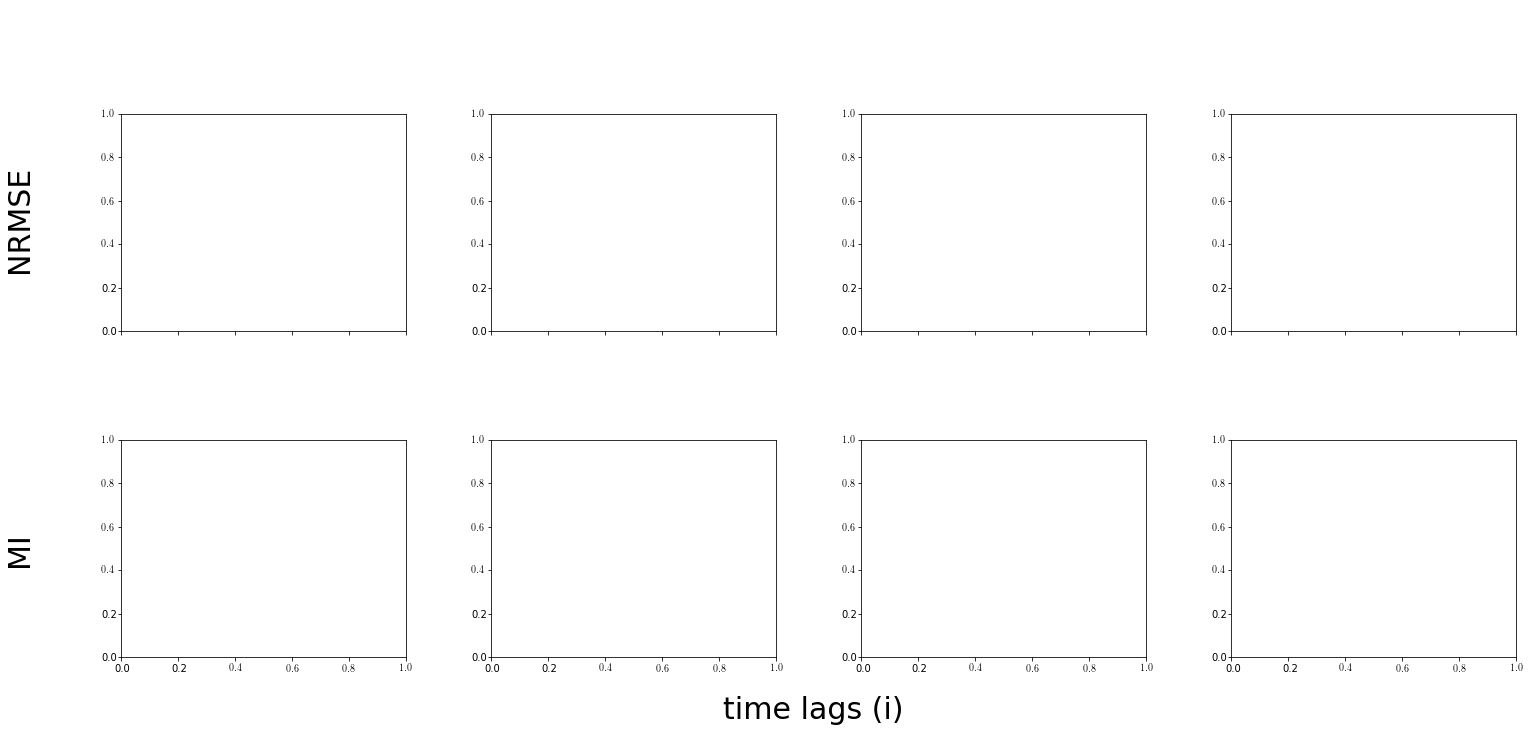

network_edge_list_modENCODE.csv
Running network...
factor i= 0.05
factor beta= 0.05
SR 0.95
Parameters: tau= 10.00 c_n= 0.01
(3000,)
Training network...
n= 0
486 trained to n =0 delay FINISHED
Plot nrmse
modENCODE => min= 16 value 0.0123163752495
n= 1
486 trained to n =1 delay FINISHED
Plot nrmse
modENCODE => min= 46 value 0.0134260912001
n= 5
486 trained to n =5 delay FINISHED
Plot nrmse
modENCODE => min= 21 value 0.0143320852729
n= 10
486 trained to n =10 delay FINISHED
Plot nrmse
modENCODE => min= 30 value 0.0188671081925


network_edge_list_YEASTRACT.csv
Running network...
factor i= 0.05
factor beta= 0.05
SR 0.95
Parameters: tau= 10.00 c_n= 0.01
(3000,)
Training network...
n= 0
289 trained to n =0 delay FINISHED
Plot nrmse
YEASTRACT => min= 16 value 0.0123163752495
n= 1
289 trained to n =1 delay FINISHED
Plot nrmse
YEASTRACT => min= 45 value 0.0129555921897
n= 5
289 trained to n =5 delay FINISHED
Plot nrmse
YEASTRACT => min= 46 value 0.0158351296023
n= 10
289 trained to n =10 delay FINISHED
Plot nrmse
YEASTRACT => min= 25 value 0.0168836491185


network_edge_list_EcoCyc.csv
Running network...
factor i= 0.05
factor beta= 0.05
SR 0.95
Parameters: tau= 10.00 c_n= 0.01
(3000,)
Training network...
n= 0
70 trained to n =0 delay FINISHED
Plot nrmse
EcoCyc => min= 16 value 0.0123163752495
n= 1
70 trained to n =1 delay FINISHED
Plot nrmse
EcoCyc => min= 45 value 0.0145155109511
n= 5
70 trained to n =5 delay FINISHED
Plot nrmse
EcoCyc => min= 47 value 0.0163611953161
n= 10
70 trained to n =10 delay FINISHED
Plot nrmse
EcoCyc => min= 29 value 0.0185562775109


network_edge_list_DBTBS.csv
Running network...
factor i= 0.05
factor beta= 0.05
SR 0.95
Parameters: tau= 10.00 c_n= 0.01
(3000,)
Training network...
n= 0
13 trained to n =0 delay FINISHED
Plot nrmse
DBTBS => min= 16 value 0.0123163752495
n= 1
13 trained to n =1 delay FINISHED
Plot nrmse
DBTBS => min= 17 value 0.0138876156455
n= 5
13 trained to n =5 delay FINISHED
Plot nrmse
DBTBS => min= 46 value 0.0171427917044
n= 10
13 trained to n =10 delay FINISHED
Plot nrmse
DBTBS => min= 28 value 0.016830640642


In [38]:
files_dict={}
for file_path in csv_files:
    filename=file_path[file_path.index("list")+5:file_path.index(".csv")]
    net,Y_n,nrmse_by_n,mi_by_n,MImax_n=test("Dataset1",file_path, "noise", 0.95,i_scaling,beta_scaling, [0,1,5,10], nrmse= False, noise=True)
    files_dict[filename]=(mi_by_n,nrmse_by_n)

network_edge_list_ENCODE.csv
Running network...
factor i= 0.05
factor beta= 0.05
SR 0.95
Parameters: tau= 10.00 c_n= 0.01
(3000,)
Training network...
n= 0
207 trained to n =0 delay FINISHED
Plot nrmse
ENCODE => min= 16 value 0.0123163752495
n= 1
207 trained to n =1 delay FINISHED
Plot nrmse
ENCODE => min= 45 value 0.0134137990782
n= 5
207 trained to n =5 delay FINISHED
Plot nrmse
ENCODE => min= 26 value 0.0181210829887
n= 10
207 trained to n =10 delay FINISHED
Plot nrmse
ENCODE => min= 35 value 0.0172837400919


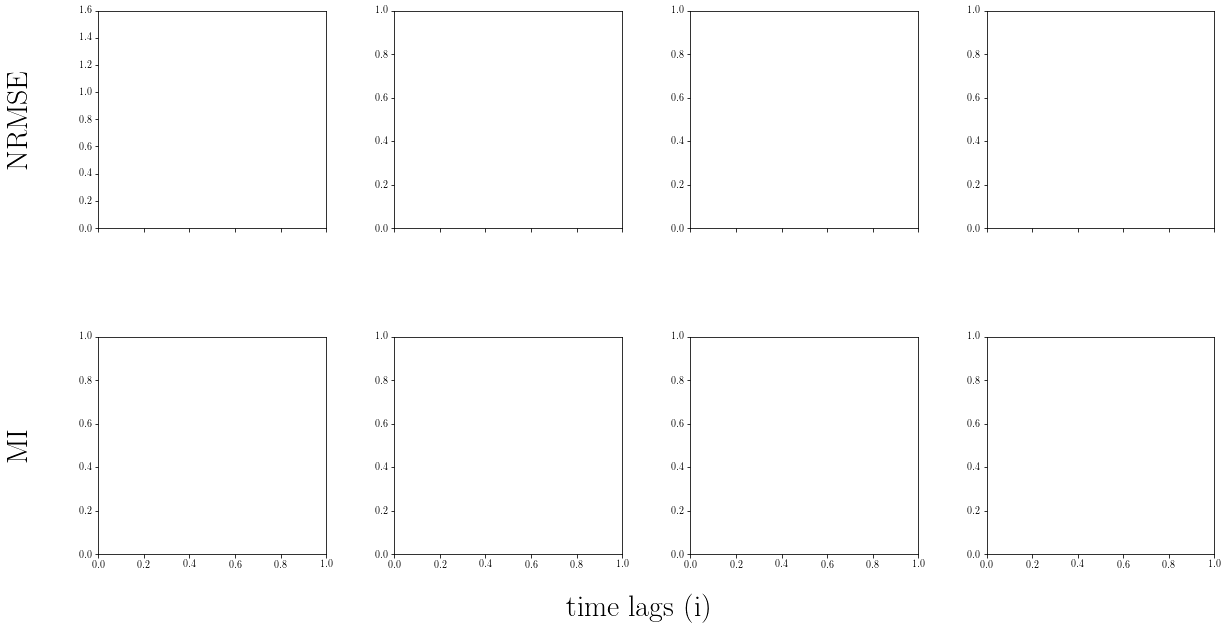

In [51]:
net,Y_n,nrmse_by_n,mi_by_n,MImax_n=test("Dataset1",file, "noise", 0.95,i_scaling,beta_scaling, [0,1,5,10], nrmse= False, noise=True)

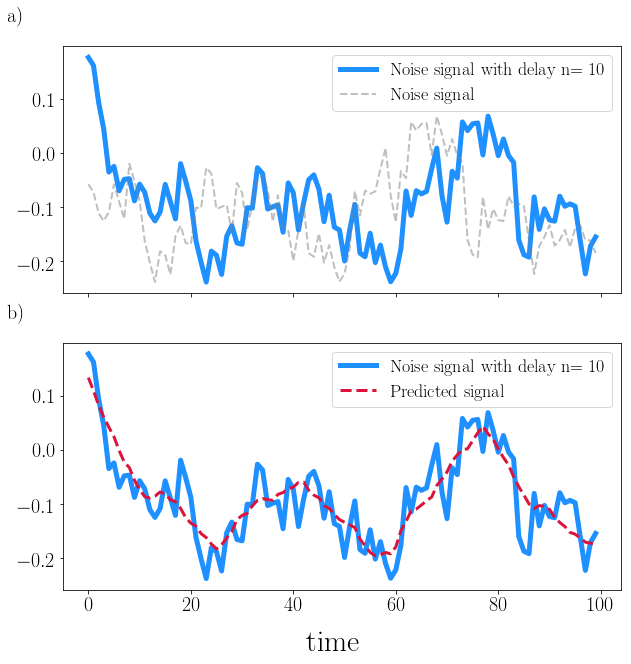

In [356]:

fig, axes = subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 10))
fig.text(0.5, 0.04, 'time', ha='center',fontsize=30)
#subplots_adjust(wspace=0.3)
ax1=axes[0]
ax2=axes[1]
ax1.text(-0.1, 1.1, "a)", transform=ax1.transAxes, size=20)       
n=10

ax1.plot( net.u[trainLen-n:trainLen+100-n], color=colors['dodgerblue'],linewidth=5 )
ax1.plot( net.u[trainLen:trainLen+100], "--",color=colors['grey'],linewidth=2,alpha=0.5)
ax1.legend(['Noise signal with delay n= {}'.format(n),"Noise signal"],fontsize=18)
ax1.tick_params(axis='both', labelsize=20)

plot_temporal_lines(net.u,Y_n[10], 10,100,"encode", tau, "none", False)

ax2.tick_params(axis='both', labelsize=20)


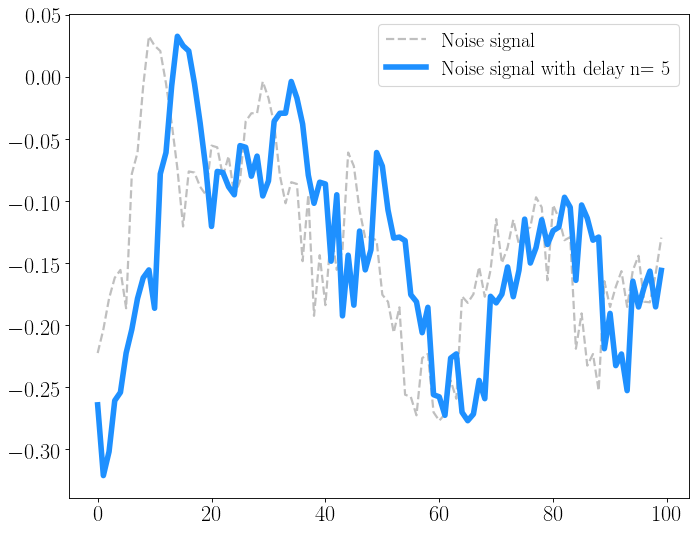

In [47]:
net,nrmse_by_n,mi_by_n,MImax_n,FWHM=test("Dataset1",file, "noise", 0.95,i_scaling,beta_scaling, n_range, nrmse= True, noise=True)

network_edge_list_ENCODE.csv
Running network...
factor i= 0.05
factor beta= 0.05
SR 0.95
Parameters: tau= 10.00 c_n= 0.01
(3000,)
Training network...
n= 0
207 trained to n =0 delay FINISHED
Plot nrmse
ENCODE => min= 0 value 0.000108246800328
n= 1
207 trained to n =1 delay FINISHED
Plot nrmse
ENCODE => min= 1 value 0.233679615435
n= 5
207 trained to n =5 delay FINISHED
Plot nrmse
ENCODE => min= 5 value 0.341695050778
n= 10
207 trained to n =10 delay FINISHED
Plot nrmse
ENCODE => min= 10 value 0.447568307257


In [ ]:
for start_point in [0,1]:
        popt,xdata,ydata=exponential_fitting(MImax_n,func_sum_exp,[0,4,0,20,0],start_point,MI=True)
        print(popt)
        #popt,xdata,ydata=exponential_fitting(MImax_n,exp_func,None,start_point,MI=True)
 
        #popt,xdata,ydata=exponential_fitting(MImax_n,func_power_law,None,start_point,MI=True)
        
        show()

In [ ]:
#tau=1
for tau in [2,3,4]:
    c_n=(1/tau)**2
    miLen=10000
    net,nrmse_by_n,mi_by_n,MImax_n,=test("Dataset1",file, "noise", 0.95,i_scaling,beta_scaling, n_range, nrmse= False, noise=True,notebook=False)
    for start_point in [0,1]:
        popt,xdata,ydata=exponential_fitting(MImax_n,func_sum_exp,None,start_point,MI=True)
        print(popt)
        show()

In [ ]:
## Parameters
tau=10
c_n=0.01

In [ ]:
#Grid search

In [ ]:
validation("Dataset1",file, "noise", 0.95,i_scaling,beta_scaling, n_range, nrmse= False, noise=True)

In [ ]:
#MI for a tau range

In [ ]:
tau_range=list(range(1,11))
MImax_n_1=[]
for tau in range(1,11):
    c_n=(1/tau)**2
    net,X,Y,nrmse_i,mi_i,filename, MImax_n,FWHM=test("Dataset1",file, "noise", 0.95, n_range, nrmse= False, noise=True)
    exponential_fitting(MImax_n, MI=True)
    MImax_n_1.append(MImax_n[1])
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plot(tau_range,MImax_n_1,"-o")
xlabel("tau")
ylabel("MI max at n=1")
show()

In [ ]:
# FULL WIDTH AT HALF MAXIMUM

In [ ]:
#Spectral radius= 1

network_edge_list_ENCODE.csv
Running network...
factor i= 0.01
factor beta= 0.10
SR 0.95
Parameters: tau= 5.00 c_n= 0.04
(4000,)


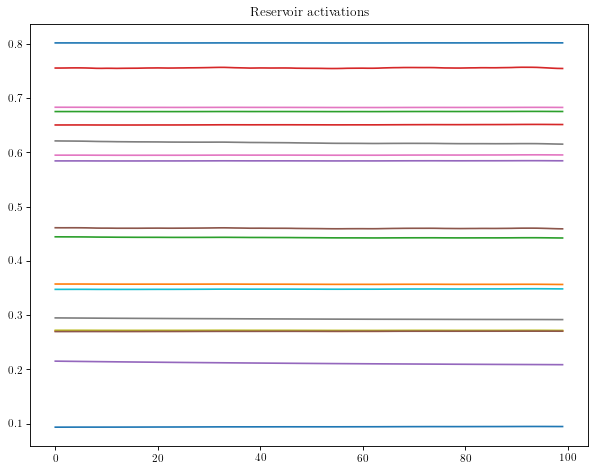

Training network...
n= 10
Autocorrelation of predicted noise
207 trained to n =10 delay FINISHED
Plot mi
ENCODE => max= 10
r1=5.595909 and r2=14.955982
FWHM 9.36007307604


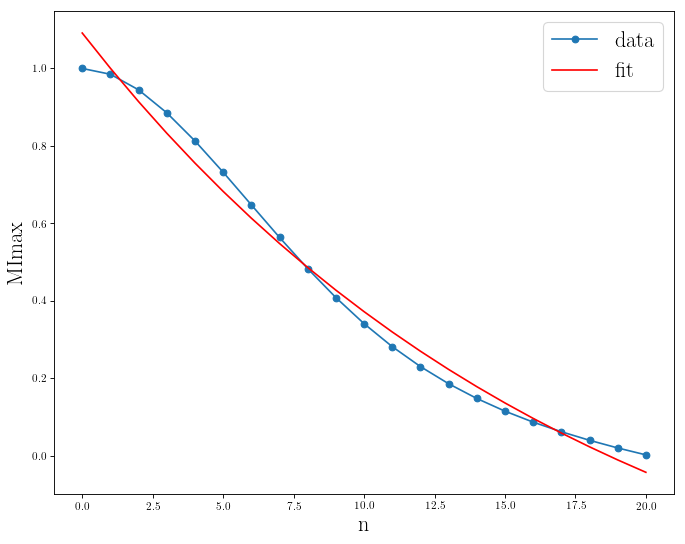

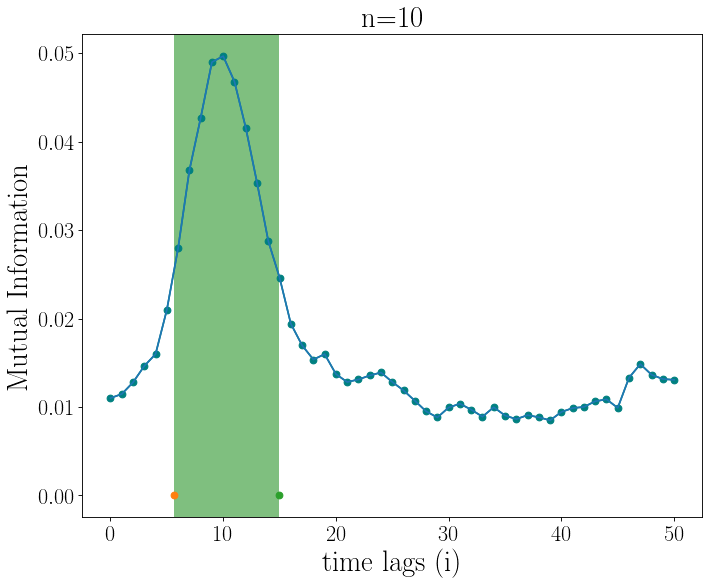

9.36007307604
network_edge_list_ENCODE.csv
Running network...
factor i= 0.01
factor beta= 0.10
SR 0.95
Parameters: tau= 10.00 c_n= 0.01
(4000,)


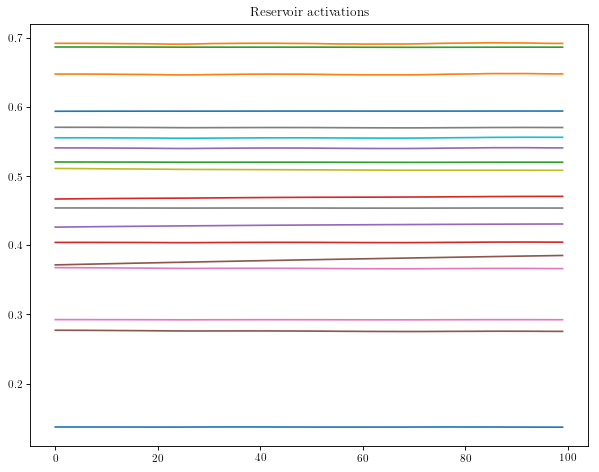

Training network...
n= 10
Autocorrelation of predicted noise
207 trained to n =10 delay FINISHED
Plot mi
ENCODE => max= 10
r1=5.744077 and r2=15.217011
FWHM 9.47293382067


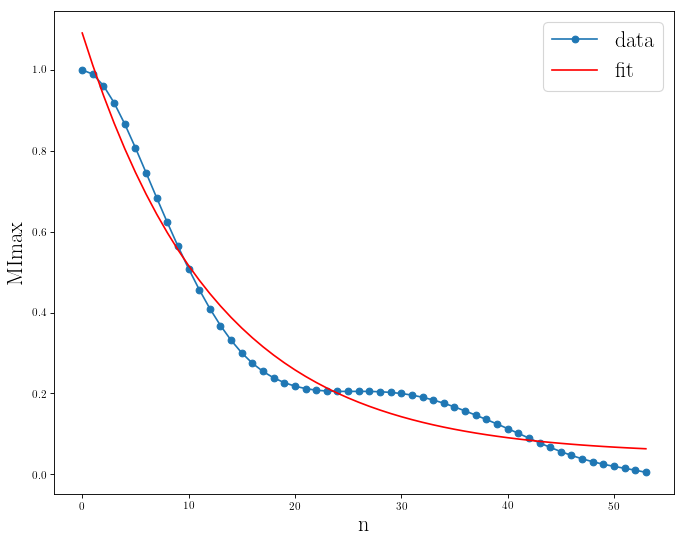

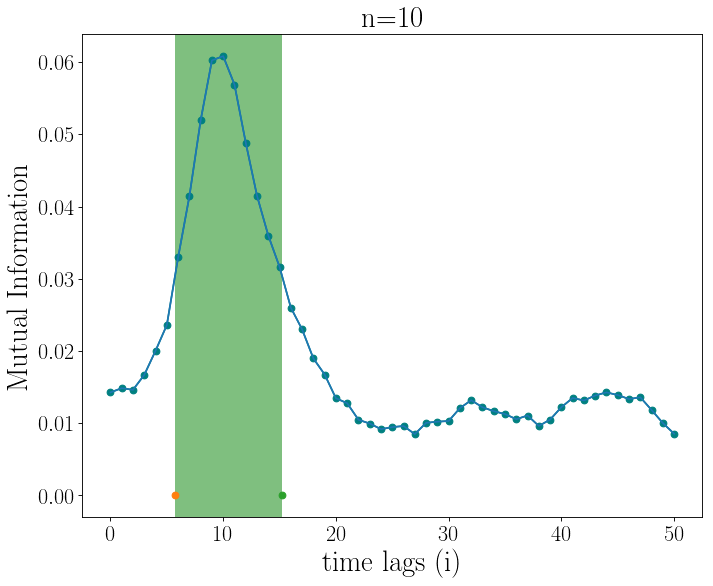

9.47293382067
network_edge_list_ENCODE.csv
Running network...
factor i= 0.01
factor beta= 0.10
SR 0.95
Parameters: tau= 20.00 c_n= 0.00
(4000,)


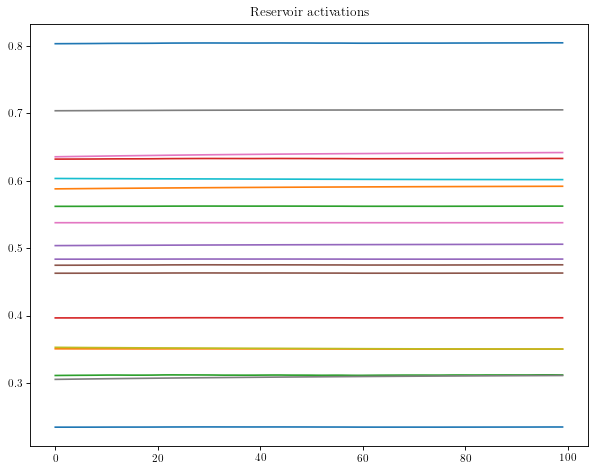

Training network...
n= 10
Autocorrelation of predicted noise
207 trained to n =10 delay FINISHED
Plot mi
ENCODE => max= 9
r1=3.407836 and r2=17.746174
FWHM 14.3383376558


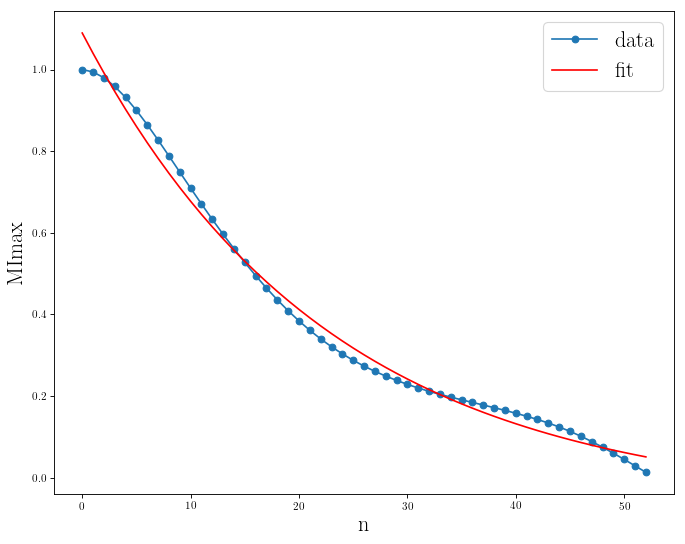

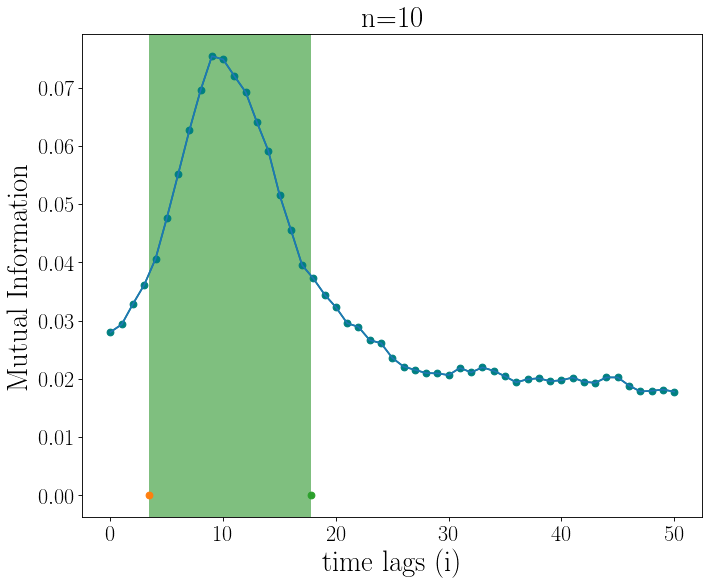

14.3383376558


In [46]:
#Spline plotting for n=15
i_scaling=0.01
beta_scaling=0.1
MI_tau={}
Nrmse_tau={}
i_max=50
for tau in [5,10,20]:
    c_n=(1/tau)**2
    net,X,Y,nrmse_i,mi_i,filename, MImax_n, FWHM=test_FWHM("Dataset1",file, "noise", 0.95, [10], nrmse= False, noise=True,gaussian=True)
    print(FWHM)
    MI_tau[tau]=mi_i
    Nrmse_tau[tau]=nrmse_i

In [ ]:
MI_tau

In [ ]:
#Spectral radius= 0.1

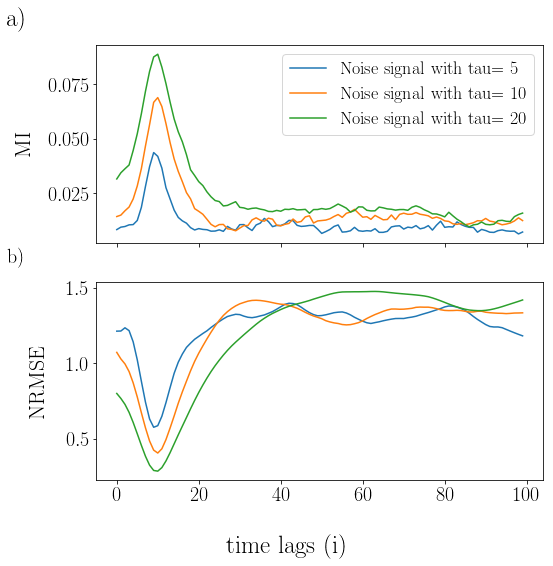

In [349]:

fig, axes = subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8, 8))
#subplots_adjust(wspace=0.3)
ax1=axes[0]
ax2=axes[1]

#ax1.subplot(1,2,1)
ax1.tick_params(axis='both', labelsize=20)
ax1.text(-0.2, 1.1, "a)", transform=ax1.transAxes, size=25)
#ax1.set_ylim(0,0.1)
legend_list=["Noise signal with tau= {}".format(tau) for tau in MI_tau]
for noise in MI_tau.keys():
    ax1.plot(list(MI_tau[noise][10].values())[:100])
ax1.text(-0.18, 0.5, 'MI', va='center',rotation="vertical",fontsize=22,transform=ax1.transAxes)
ax1.legend(legend_list,fontsize=18)
#figure(num=None, figsize=(5, 8),dpi=80,facecolor='w', edgecolor='k')
#ax2 = subplot(1,2,2)
ax2.text(-0.2, 1.1, "b)", transform=ax2.transAxes, size=20)
ax2.tick_params(axis='both', labelsize=20)
ax2.text(-0.15, 0.5, 'NRMSE', va='center',rotation="vertical",fontsize=22,transform=ax2.transAxes)
legend_list=["Noise signal with tau= {}".format(tau) for tau in MI_tau]
labels=[]
#ax2.set_ylim(0,1.6)
for noise in MI_tau.keys():
    h1=ax2.plot(list(Nrmse_tau[noise][10].values())[:100])
    labels.append(h1[0])
#ax2.legend(legend_list,fontsize=18)
#fig.legend(labels ,legend_list,loc=1)
fig.text(0.35, 0.01, 'time lags (i)', va='center',fontsize=25)
show()

In [ ]:
#Spline plotting for n=15
i_scaling=0.01
beta_scaling=0.1
net,X,Y,nrmse_i,mi_i,filename, MImax_n, FWHM=test("Dataset1",file, "noise", 1, [15], nrmse= False, noise=True,gaussian=True)

In [ ]:
#range beta scaling and FWHM

In [ ]:
i_scaling=0.01
beta_scaling_range=[0.01,0.5,0.9,1.2]
FWHM_range=[]
for beta_scaling in beta_scaling_range:
    net,X,Y,nrmse_i,mi_i,filename, MImax_n, FWHM=test("Dataset1",file, "noise", 1, [15], nrmse= False, noise=True,gaussian=True)
    FWHM_range.append(FWHM)
plot(i_scaling_range,FWHM_range, "-o")
title("FWHM rho= %.2f, i_scaling=%.2f"%(1,i_scaling))
xlabel("i_scaling")
ylabel("FWHM")
show()

In [ ]:
np.arange([0.5,1])

In [ ]:
#range rho scaling and FWHM and MImax

In [ ]:
i_scaling=0.1
beta_scaling=0.05
rho_range=[0.1,0.3,0.5,1,1.5]
MImax_range=[]
FWHM_list=[]
for rho in rho_range:
    net,nrmse_i,mi_i, MImax_n, FWHM=test("Dataset1",file, "noise", rho,i_scaling,beta_scaling, [30], nrmse= False, noise=True,gaussian=True)
    MImax_range.append(MImax_n[30])
    FWHM_list.append(FWHM)

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plot(rho_range,MImax_range, "-o")
title("MImax n=15 beta_scaling= %.2f, i_scaling=%.2f n=15"%(beta_scaling,i_scaling))
xlabel("rho")
ylabel("MImax value")

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plot(rho_range,FWHM_list, "-o")
title("FWHM n=15 beta_scaling= %.2f, i_scaling=%.2f n=15"%(beta_scaling,i_scaling))
xlabel("rho")
ylabel("FWHM")

show()

In [ ]:
plot(MImax_range, FWHM_list)
show()

In [ ]:
#range SR and NRMSE

In [ ]:
#i_scaling=1
tau=10
c_n=0.01
beta_scaling=0.9
i_scaling=0.01
rho_range=[0.1,0.3,0.5,1,1.5]
nrmse_range=[]
for rho in rho_range:
    net,X,Y,nrmse_i,mi_i,filename, MImax_n, FWHM=test("Dataset1",file, "noise", rho, [0], nrmse= True, noise=True,gaussian=False)
    nrmse_range.append(min(nrmse_i[0].values()))
plot(rho_range,nrmse_range, "-o")
title("SR vs NRMSE i_scaling= %.2f, beta_scaling=%.2f"%(i_scaling,beta_scaling))
xlabel("rho")
ylabel("NRMSE min at n=0")
show()

In [ ]:
## WHITE NOISE
## Parameters
tau=0.01
c_n=1

In [ ]:
#Mi
net,X,Y,nrmse_i,mi_i,filename, MImax_n_tau_100=test("Dataset1",file, "noise", 0.95, n_range, nrmse= False, noise=True)
exponential_fitting(MImax_n_tau_100, MI=True)

In [ ]:
#ALL FILES

In [ ]:
#Nrmse
test_all("Dataset1","noise", 0.95, n_range, nrmse=True, noise=True, euler=True, save=False)

In [ ]:
#MI
test_all("Dataset1","noise", 0.95, n_range, nrmse=False, noise=True)

In [ ]:
#                             RESULTS  ROSSLER                                          #

In [ ]:
# SINGLE FILE:
file=csv_files[0]

## N range
n_range= list(range(10))
i_max=80

In [ ]:
## Parameters
a=0.15
b=0.20
c=10


In [ ]:
# EULER

In [ ]:
## Nrmse
X,Y,nrmse_i,mi_i,filename=test("Dataset1",file, "rossler", 0.95, n_range, nrmse=True, noise=False, euler=True)

In [ ]:
## Mi
X,Y,nrmse_i,mi_i,filename,MImax_n=test("Dataset1",file, "rossler", 0.95, n_range, nrmse=False, noise=False, euler=True)

In [ ]:
plot(MImax_n.keys(), MImax_n.values())
show()

In [ ]:
##ALL FILES
#Nrmse
test_all("Dataset1","rossler", 0.95, n_range, nrmse=True, noise=False, euler=True, save=False)

In [ ]:
##ALL FILES
#Mi
test_all("Dataset1","rossler", 0.95, n_range, nrmse=False, noise=False, euler=True, save=False)

In [ ]:
# ODEINT

In [ ]:
## Nrmse
X,Y,nrmse_i,mi_i,filename=test("Dataset1",file, "rossler", 0.95, n_range, nrmse=True, noise=False, euler= False)

In [ ]:
## Mi
X,Y,nrmse_i,mi_i,filename=test("Dataset1",file, "rossler", 0.95, n_range, nrmse=False, noise=False, euler= False)

In [ ]:
##ALL FILES
#Nrmse
test_all("Dataset1","rossler", 0.95, n_range, nrmse=True, noise=False, euler=False, save=False)

In [ ]:
##ALL FILES
#Mi
test_all("Dataset1","rossler", 0.95, n_range, nrmse=False, noise=False, euler=False, save=False)